### **참고** 
- 이미지넷 대회데이터는 너무 방대하기 때문에 실습코드 데이터는 CIFAR-10데이터를 사용함
- 현재 GPU 2대를 따로 연결할 실습환경이 안되므로 GPU 1대 실행 (AlexNet처럼 Multiple GPUs를 사용할 일은 드뭄.) 

In [1]:
''' Module Import'''
import numpy as np
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision
from torchvision import transforms, datasets

In [2]:
''' 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using PyTorch version: {torch.__version__}, Device: {DEVICE}')
BATCH_SIZE = 16
EPOCHS = 3

Using PyTorch version: 1.8.1, Device: cuda


In [3]:
''' 이미지 transform'''
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(196),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [4]:
''' CIFAR10 데이터 다운로드(Train set, Test set 분리하기) '''
train_dataset = datasets.CIFAR10(root = './data/CIFAR_10', 
                                      train = True, 
                                      download = True,
                                      transform = transform) 

test_dataset = datasets.CIFAR10(root = './data/CIFAR_10',
                                      train = False,
                                      download = True,
                                      transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
                                                
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

In [6]:
''' 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print(f'X_train: {X_train.size()}, type: {X_train.type()}')
    print(f'y_train: {y_train.size()}, type: {y_train.type()}')
    break

X_train: torch.Size([16, 3, 196, 196]), type: torch.FloatTensor
y_train: torch.Size([16]), type: torch.LongTensor


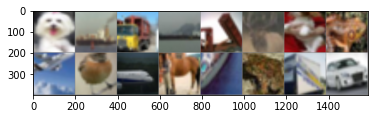

  dog  ship truck  ship truck  deer   dog  forg plane  bird plane horse  ship  forg truck   car


In [7]:
classes = ('plane','car','bird','cat','deer','dog','forg','horse','ship','truck')

''' 데이터 확인하기 (2) '''
def imshow(img):
    img = (img+1) / 2
    nping = img.numpy()
    plt.imshow(np.transpose(nping, (1,2,0)))
    plt.show()
    

dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s'%classes[labels[j]] for j in range(16)))

In [8]:
'''모델 설계'''
# Alexnet 모델 (1번)
class AlexNet(nn.Module):
  def __init__(self, num_classes = 10):
    super(AlexNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4)             # output_size : 55 * 55
    self.batch1 = nn.BatchNorm2d(96),
    self.conv2 = nn.Conv2d(96, 256, kernel_size=5, padding=2, groups=2) # output_size : 27 * 27
    self.conv3 = nn.Conv2d(256, 384, kernel_size=3, padding=1)           # output_size : 27 * 27
    self.conv4 = nn.Conv2d(384, 384, kernel_size=3, padding=1, groups=2) # output_size : 13 * 13
    self.conv5 = nn.Conv2d(384, 256, kernel_size=3, padding=1, groups=2)
    
    self.fc1 = nn.Linear(256*5*5, 4096)
    self.fc2 = nn.Linear(4096, 4096)
    self.fc3 = nn.Linear(4096, num_classes)

  
  def forward(self, x):
    x = F.relu(self.conv1(x))                    # output_size : 55 * 55
    x = F.max_pool2d(x, kernel_size=3, stride=2) # output_size : 27 * 27
    x = F.relu(self.conv2(x))                    # output_size : 27 * 27
    x = F.max_pool2d(x, kernel_size=3, stride=2) # output_size : 13 * 13
    x = F.relu(self.conv3(x))                    # output_size : 13 * 13 
    x = F.relu(self.conv4(x))                    # output_size : 13 * 13 
    x = F.relu(self.conv5(x))                    # output_size : 13 * 13 
    x = F.max_pool2d(x, kernel_size=3, stride=2) # output_size : 6 * 6

    x = x.view(x.size(0), -1)                    # 1차원 vector로 변환 (fc층의 입력으로 들어가기 위해서)
    x = F.dropout(x)                             # output_size : 9216
    x = F.relu(self.fc1(x))                      # output_size : 4096
    x = F.dropout(x)                             # output_size : 4096
    x = F.relu(self.fc2(x))                      # output_size : 4096 
    x = self.fc3(x)                              # output_size : 10

    return x 

In [9]:
'''모델 설계'''
# AlexNet 모델 (2번)
class AlexNet_LRN(nn.Module):
    def __init__(self, num_classes: int = 10):
        super(AlexNet_LRN, self).__init__()
        self.convnet = nn.Sequential(
            # Input Channel (RGB: 3)
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11,stride=4), # 227 -> 55
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75),
            nn.MaxPool2d(kernel_size=3, stride=2), # 55 -> 27
            
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2, stride=1), # 27 -> 27
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75),
            nn.MaxPool2d(kernel_size=3, stride=2), # 27 -> 13
            
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75),
            nn.MaxPool2d(kernel_size=3, stride=2), # 13 -> 6
        )

        self.fclayer = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
    
    def forward(self, x:torch.Tensor):
        x = self.convnet(x)
        x = torch.flatten(x, 1)
        x = self.fclayer(x)
        return x

In [10]:
'''모델 설계'''
# AlexNet 모델 (3번)
class AlexNet_BN(nn.Module):
    def __init__(self, num_classes: int = 10, init_weights: bool = True):
        super(AlexNet_BN, self).__init__()
        self.convnet = nn.Sequential(
            # Input Channel (RGB: 3)
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11,stride=4), # 227 -> 55
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # 55 -> 27
            
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2, stride=1), # 27 -> 27
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # 27 -> 13
            
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # 13 -> 6
        )

        self.fclayer = nn.Sequential(
            nn.Linear(256 * 5 * 5, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
    
    def forward(self, x:torch.Tensor):
        x = self.convnet(x)
        x = torch.flatten(x, 1)
        x = self.fclayer(x)
        return x

In [11]:
''' Optimizer, Objective function 설정하기 '''
model = AlexNet_BN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
print(model)

AlexNet_BN(
  (convnet): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
    (15): MaxP

In [12]:
''' MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train() 
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        # ------------- forward propagation
        optimizer.zero_grad()
        output = model(image)
        # ------------- backward propagation
        loss = criterion(output, label)
        loss.backward() 
        optimizer.step() 
        
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {Epoch} \
                    [{batch_idx * len(image)} / {len(train_loader.dataset)}] ({batch_idx / len(train_loader) * 100:.0f}%) \
                    Train Loss: {loss.item():.6f}')

In [13]:
''' 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval() 
    test_loss = 0 
    correct = 0 
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            
            test_loss += criterion(output, label).item() 
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset) * 100
    return test_loss, test_accuracy

In [14]:
''' MLP 학습을 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print(f'[EPOCH: {Epoch}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}]')

Train Epoch: 1                     [0 / 50000] (0%)                     Train Loss: 2.310997
Train Epoch: 1                     [3200 / 50000] (6%)                     Train Loss: 1.935134
Train Epoch: 1                     [6400 / 50000] (13%)                     Train Loss: 2.288582
Train Epoch: 1                     [9600 / 50000] (19%)                     Train Loss: 2.209921
Train Epoch: 1                     [12800 / 50000] (26%)                     Train Loss: 2.537317
Train Epoch: 1                     [16000 / 50000] (32%)                     Train Loss: 2.333408
Train Epoch: 1                     [19200 / 50000] (38%)                     Train Loss: 2.735022
Train Epoch: 1                     [22400 / 50000] (45%)                     Train Loss: 2.532932
Train Epoch: 1                     [25600 / 50000] (51%)                     Train Loss: 2.411971
Train Epoch: 1                     [28800 / 50000] (58%)                     Train Loss: 2.210329
Train Epoch: 1               